# **Providing data-driven suggestions for HR**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)


from xgboost import XGBClassifier
from xgboost import XGBRegressor
from xgboost import plot_importance

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.tree import plot_tree

import pickle

In [2]:
df0 = pd.read_csv("Salifort_motors.csv")
df0.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [3]:
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   Department             14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


In [4]:
df0.describe()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.612834,0.716102,3.803054,201.050337,3.498233,0.144610,0.238083,0.021268
std,0.248631,0.171169,1.232592,49.943099,1.460136,0.351719,0.425924,0.144281
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000
50%,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000
75%,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000


In [5]:
df0.columns

Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_montly_hours', 'time_spend_company', 'Work_accident', 'left',
       'promotion_last_5years', 'Department', 'salary'],
      dtype='object')

In [6]:
df0 = df0.rename(columns={'Work_accident': 'work_accident',
                         'average_montly_hours': 'average_monthly_hours',
                         'time_spend_company' : 'tenure',
                         'Department': 'department'})

df0.columns

Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_monthly_hours', 'tenure', 'work_accident', 'left',
       'promotion_last_5years', 'department', 'salary'],
      dtype='object')

In [7]:
df0.isna().sum()


satisfaction_level       0
last_evaluation          0
number_project           0
average_monthly_hours    0
tenure                   0
work_accident            0
left                     0
promotion_last_5years    0
department               0
salary                   0
dtype: int64

In [8]:
df0.duplicated().sum()

3008

In [9]:
df0[df0.duplicated()].head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,left,promotion_last_5years,department,salary
396,0.46,0.57,2,139,3,0,1,0,sales,low
866,0.41,0.46,2,128,3,0,1,0,accounting,low
1317,0.37,0.51,2,127,3,0,1,0,sales,medium
1368,0.41,0.52,2,132,3,0,1,0,RandD,low
1461,0.42,0.53,2,142,3,0,1,0,sales,low


In [10]:
df1 =  df0.drop_duplicates(keep='first')

df1.head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,left,promotion_last_5years,department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


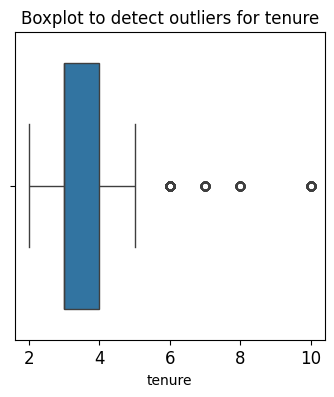

In [11]:
plt.figure(figsize = (4,4))
plt.title('Boxplot to detect outliers for tenure', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
sns.boxplot(x=df1['tenure'])
plt.show()

In [12]:
percentile25 = df1['tenure'].quantile(0.25)
percentile75 = df1['tenure'].quantile(0.75)

iqr = percentile75 - percentile25

upper_limit = percentile75 + 1.5 * iqr
lower_limit = percentile25 - 1.5 * iqr

print("Lower limit:", lower_limit)
print("Upper limit:", upper_limit)

outliers = df1[(df1['tenure'] > upper_limit) | (df1['tenure'] < lower_limit)]

print("The number of outliers in the data containg in tenure :", len(outliers))

Lower limit: 1.5
Upper limit: 5.5
The number of outliers in the data containg in tenure : 824


# Analyze Stage

In [13]:
print(df1['left'].value_counts())
print()
print(df1['left'].value_counts(normalize = True))

left
0    10000
1     1991
Name: count, dtype: int64

left
0    0.833959
1    0.166041
Name: proportion, dtype: float64


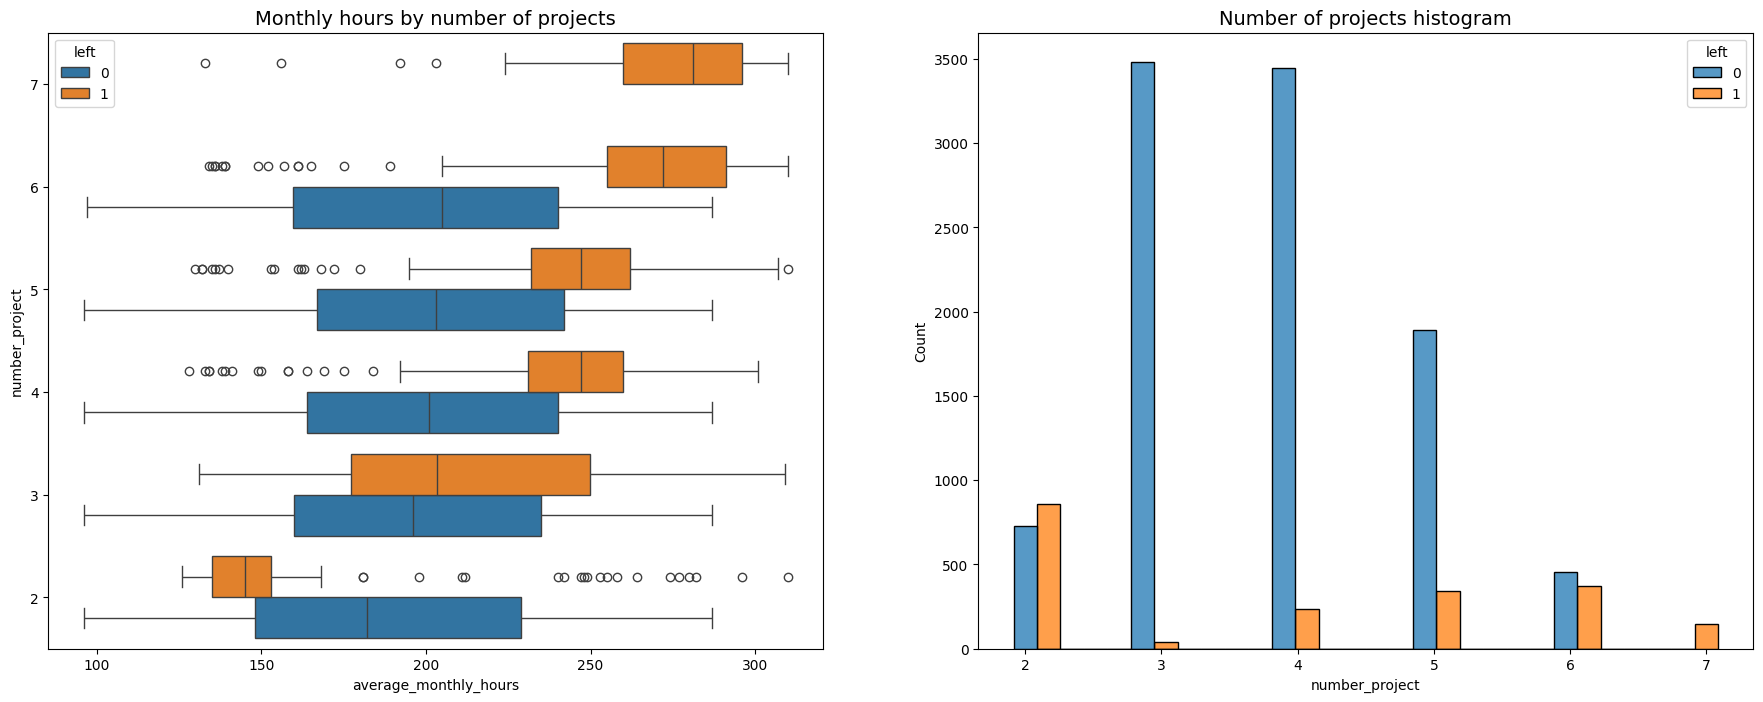

In [14]:
fig, ax= plt.subplots(1,2, figsize = (22,8))

sns.boxplot(data = df1, x='average_monthly_hours', y = 'number_project', hue = 'left',orient = "h",ax = ax[0])
ax[0].invert_yaxis()
ax[0].set_title('Monthly hours by number of projects', fontsize='14')

tenure_stay = df1[df1['left'] == 0]['number_project']
tenure_left = df1[df1['left'] == 1]['number_project']
sns.histplot(data =df1, x = 'number_project', hue = 'left',multiple = 'dodge',shrink=2,ax = ax[1])
ax[1].set_title('Number of projects histogram', fontsize='14')

plt.show()

In [15]:
df1[df1['number_project'] == 7]['left'].value_counts()

left
1    145
Name: count, dtype: int64

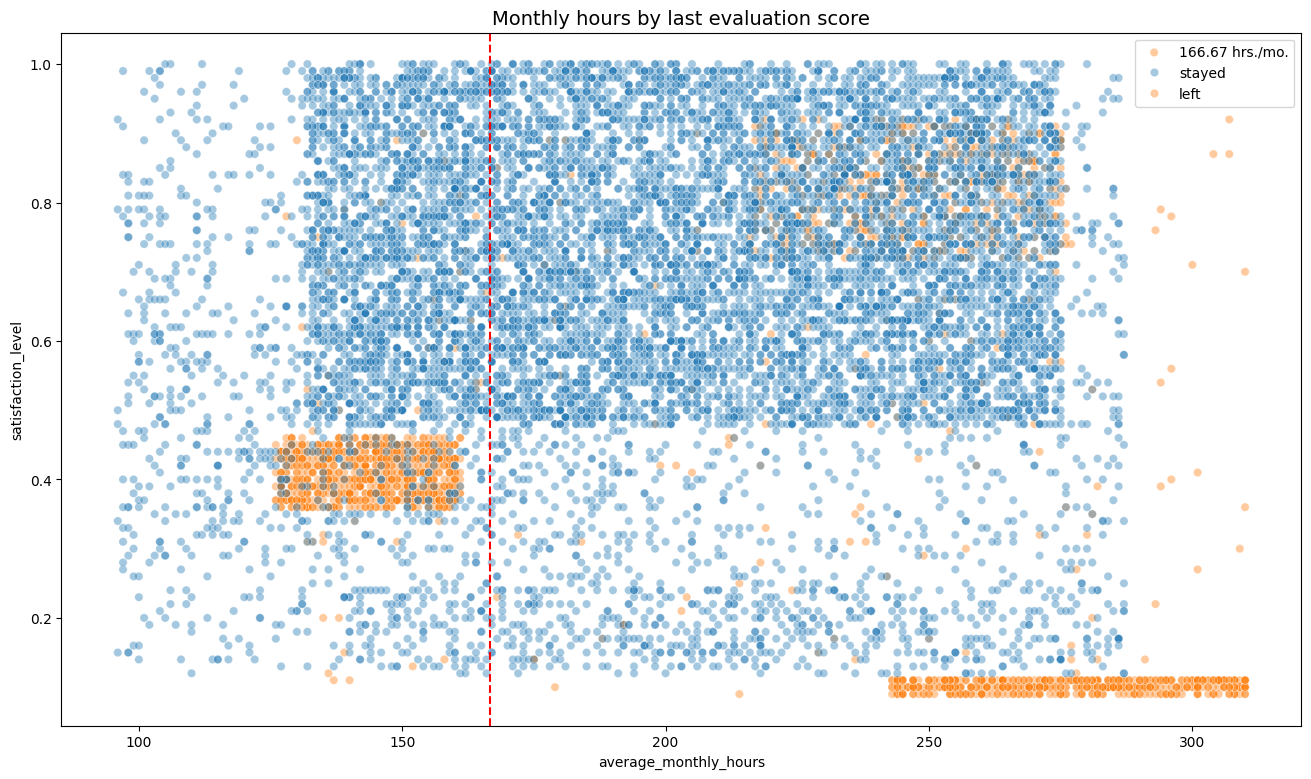

In [16]:
plt.figure(figsize = (16,9))

sns.scatterplot(data = df1, x ='average_monthly_hours', y='satisfaction_level',hue ='left', alpha = 0.4 )
plt.axvline(x=166.67, color = '#ff0000', label = '166.67 hrs/mo', ls = '--')
plt.legend(labels=['166.67 hrs./mo.', 'stayed', 'left'])
plt.title('Monthly hours by last evaluation score', fontsize='14');

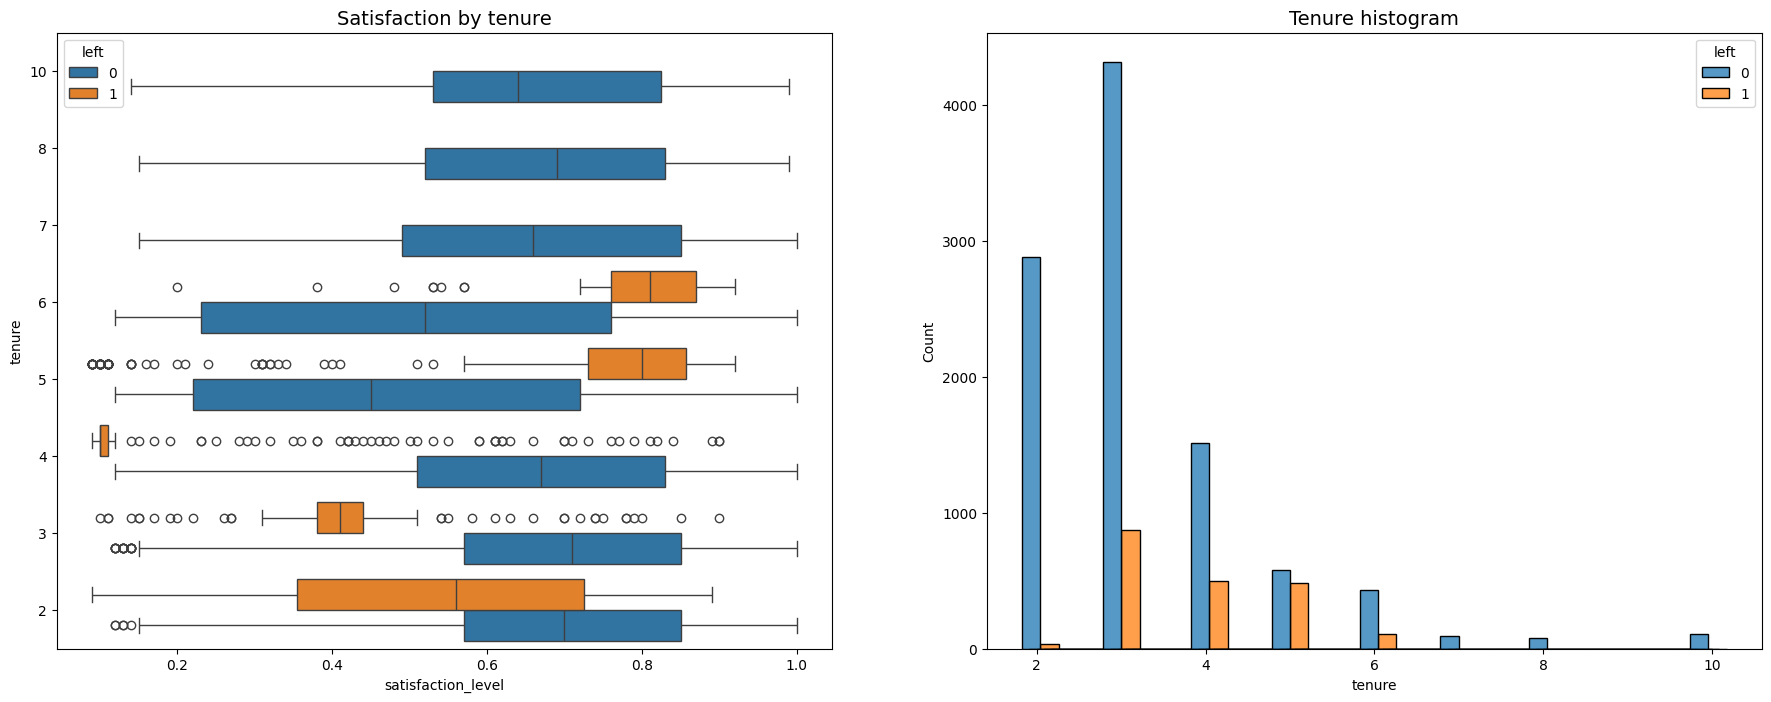

In [17]:
fig, ax = plt.subplots(1,2, figsize=(22,8))

sns.boxplot(data = df1, x="satisfaction_level", y='tenure', hue='left',orient='h',ax=ax[0])
ax[0].invert_yaxis()
ax[0].set_title('Satisfaction by tenure', fontsize='14')

tenure_stay = df1[df1['left']==0]['tenure']
tenure_left = df1[df1['left']==1]['tenure']
sns.histplot(data=df1, x='tenure', hue='left', multiple ='dodge',shrink=5,ax=ax[1])
ax[1].set_title('Tenure histogram', fontsize='14')

plt.show()

In [18]:
df1.groupby(['left'])['satisfaction_level'].agg([np.mean,np.median])

C:\Users\Sudev Sudhish\AppData\Local\Temp\ipykernel_13056\1804090797.py:1: FutureWarning: The provided callable <function mean at 0x000001CCF10ACFE0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  df1.groupby(['left'])['satisfaction_level'].agg([np.mean,np.median])
C:\Users\Sudev Sudhish\AppData\Local\Temp\ipykernel_13056\1804090797.py:1: FutureWarning: The provided callable <function median at 0x000001CCF11D4AE0> is currently using SeriesGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  df1.groupby(['left'])['satisfaction_level'].agg([np.mean,np.median])


,mean,median
left,,
0,0.667365,0.69
1,0.440271,0.41


Text(0.5, 1.0, 'Salary histogram by tenure: long-tenured people')

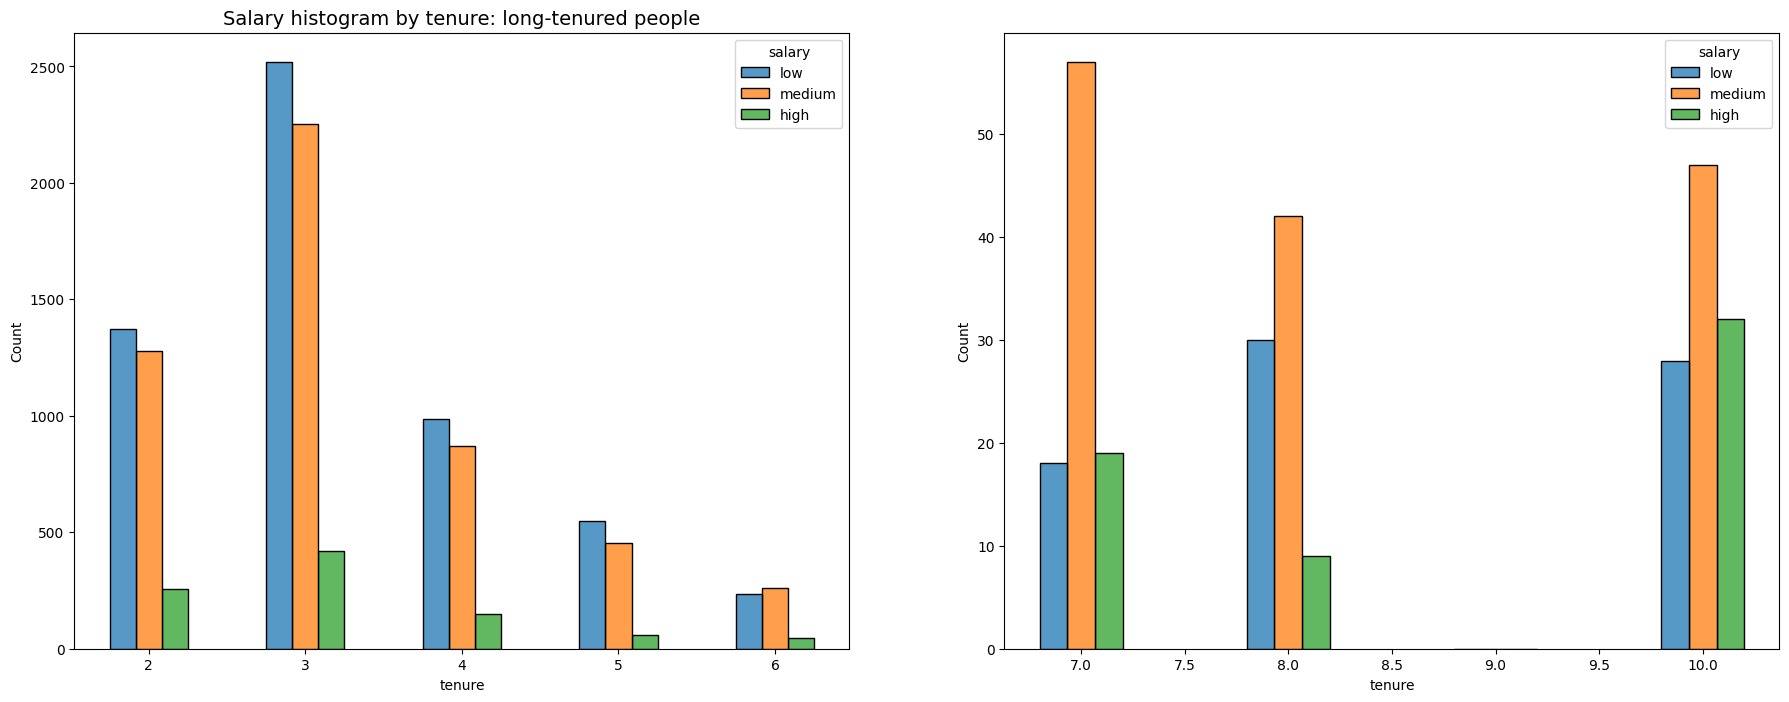

In [19]:
fig, ax = plt.subplots(1,2, figsize = (22,8))
tenure_short = df1[df1['tenure']<7]
tenure_long = df1[df1['tenure']>6]

sns.histplot(data = tenure_short, x='tenure', hue='salary', discrete=1,
            hue_order=['low','medium','high'], multiple='dodge', shrink = 0.5, ax = ax[0] )
ax[0].set_title('Salary histogram by tenure: short-tenured people', fontsize='14')

sns.histplot(data = tenure_long, x='tenure', hue='salary', discrete=1,
            hue_order=['low','medium','high'], multiple='dodge', shrink = 0.4, ax = ax[1] )
ax[0].set_title('Salary histogram by tenure: long-tenured people', fontsize='14')


Text(0.5, 1.0, 'Monthly hours by last evaluation score')

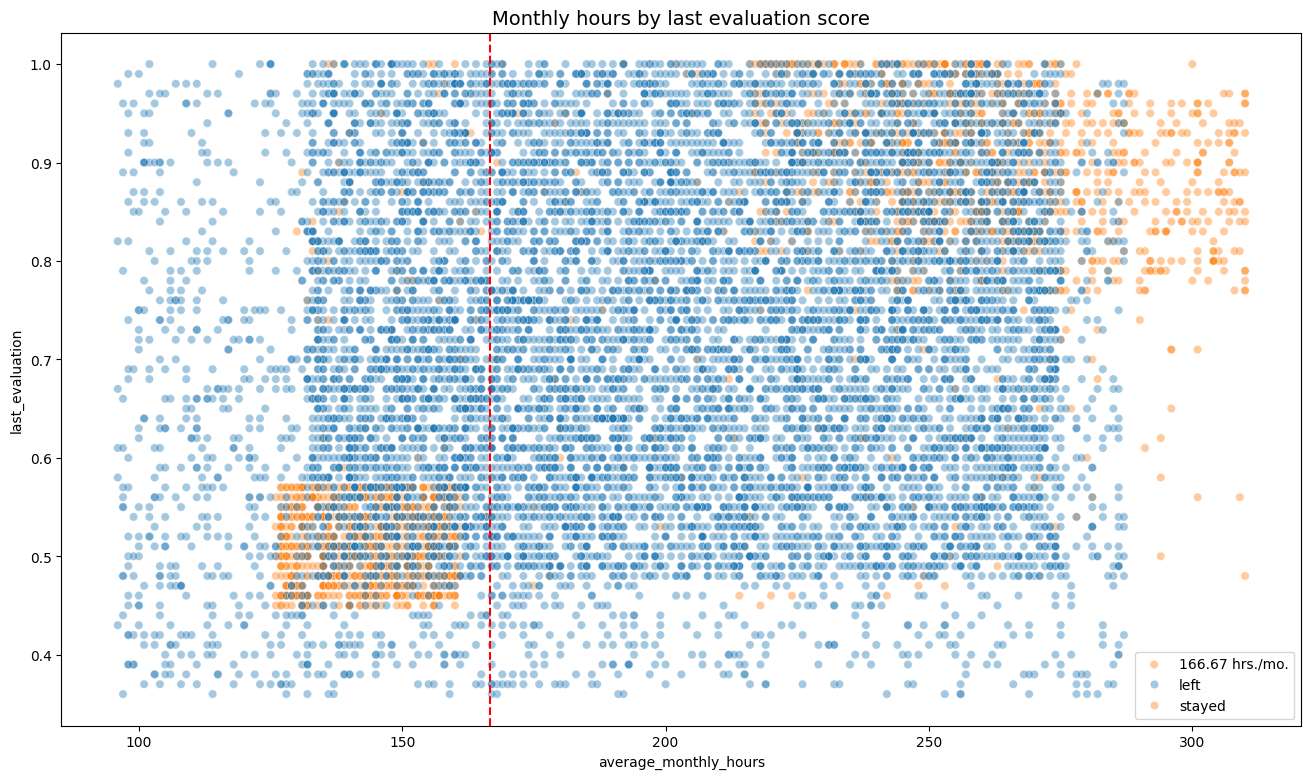

In [20]:
plt.figure(figsize=(16,9))

sns.scatterplot(data=df1, x='average_monthly_hours', y='last_evaluation', hue='left', alpha=0.4)
plt.axvline(x=166.67, color='#ff0000', label='166.67 hrs./mo.', ls='--')
plt.legend(labels=['166.67 hrs./mo.', 'left', 'stayed'])
plt.title('Monthly hours by last evaluation score', fontsize='14')

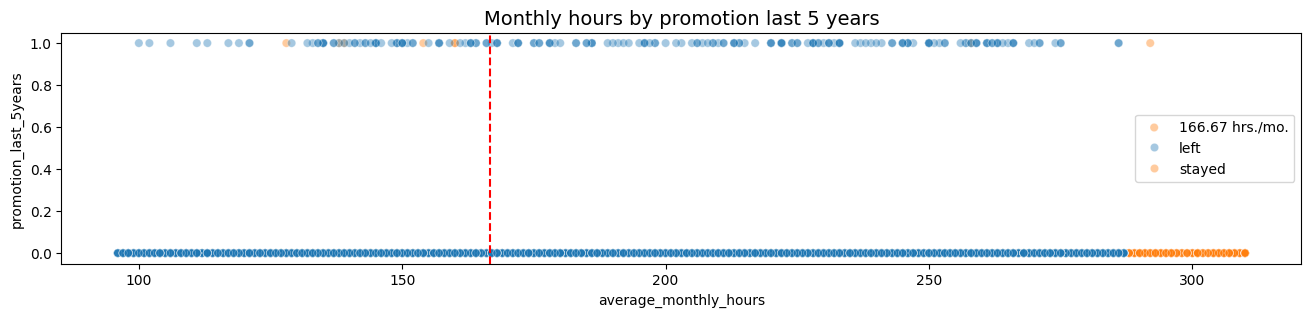

In [21]:
plt.figure(figsize=(16,3))
sns.scatterplot(data=df1, x= 'average_monthly_hours', y='promotion_last_5years', hue='left', alpha=0.4)
plt.axvline(x=166.67, color='#ff0000', ls='--')
plt.legend(labels=['166.67 hrs./mo.', 'left', 'stayed'])
plt.title('Monthly hours by promotion last 5 years', fontsize='14');

In [22]:
df1['department'].value_counts()

department
sales          3239
technical      2244
support        1821
IT              976
RandD           694
product_mng     686
marketing       673
accounting      621
hr              601
management      436
Name: count, dtype: int64

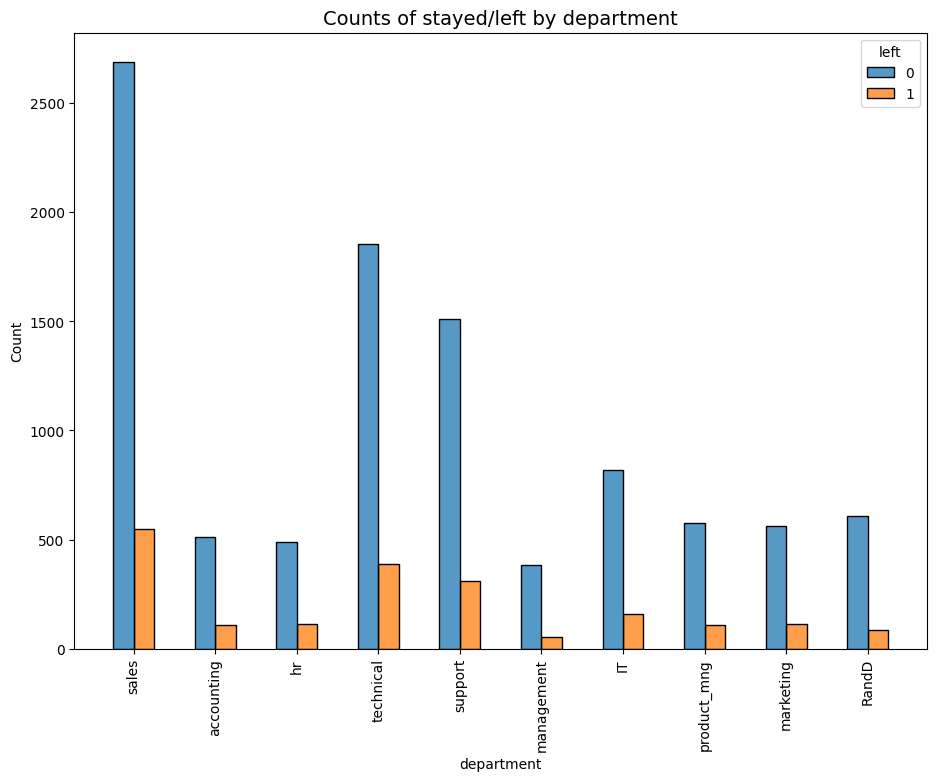

In [23]:
plt.figure(figsize=(11,8))
sns.histplot(data= df1, x='department', hue='left',discrete=1, hue_order =[0,1], multiple='dodge', shrink=0.5)

plt.xticks(rotation='vertical')
plt.title('Counts of stayed/left by department', fontsize=14);

In [24]:
df1_numeric = df1.select_dtypes(include=[float, int])

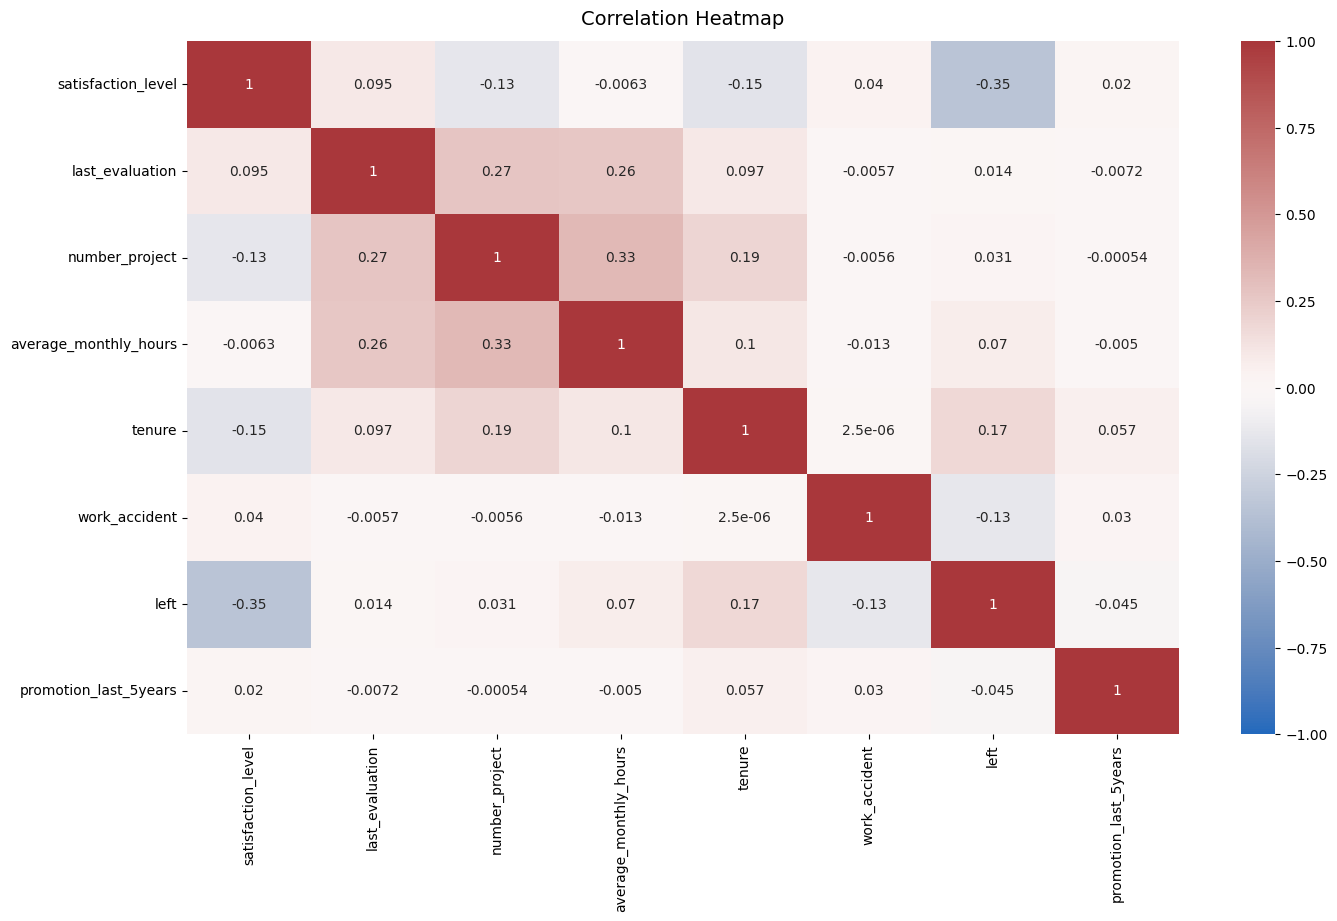

In [25]:
plt.figure(figsize=(16, 9))
heatmap = sns.heatmap(df1_numeric.corr(), vmin=-1, vmax=1, annot=True, cmap=sns.color_palette("vlag", as_cmap=True))
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':14}, pad=12);
plt.show()

### Modeling Approach A: Logistic Regression Model

In [26]:
df_enc = df1.copy()

df_enc['salary'] = (
    df_enc['salary'].astype('category')
    .cat.set_categories(['low','medium','high'])
    .cat.codes
)

df_enc = pd.get_dummies(df_enc, drop_first=False)

df_enc.head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,left,promotion_last_5years,salary,department_IT,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical
0,0.38,0.53,2,157,3,0,1,0,0,False,False,False,False,False,False,False,True,False,False
1,0.80,0.86,5,262,6,0,1,0,1,False,False,False,False,False,False,False,True,False,False
2,0.11,0.88,7,272,4,0,1,0,1,False,False,False,False,False,False,False,True,False,False
3,0.72,0.87,5,223,5,0,1,0,0,False,False,False,False,False,False,False,True,False,False
4,0.37,0.52,2,159,3,0,1,0,0,False,False,False,False,False,False,False,True,False,False


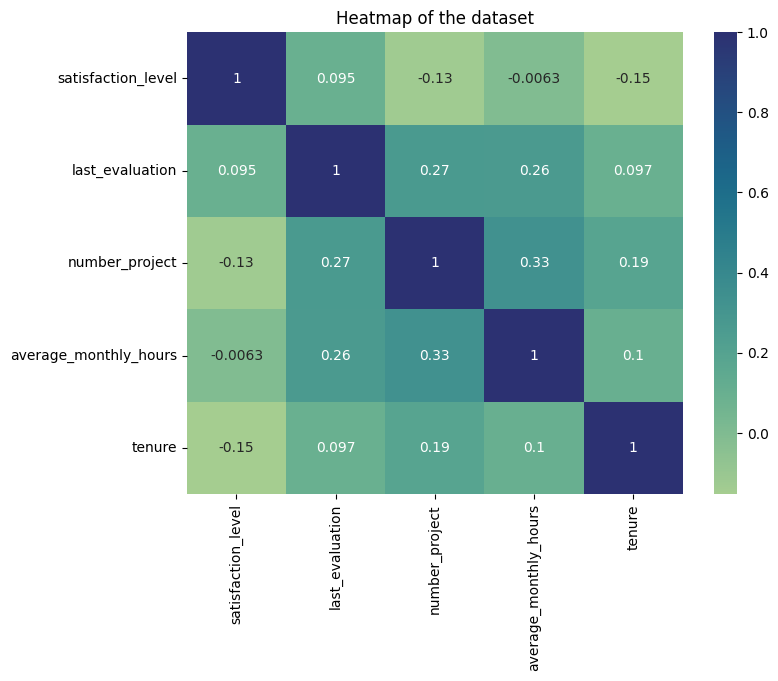

In [27]:
plt.figure(figsize=(8,6))
sns.heatmap(df_enc[['satisfaction_level', 'last_evaluation', 'number_project', 'average_monthly_hours', 'tenure']]
            .corr(), annot=True, cmap="crest")
plt.title('Heatmap of the dataset')
plt.show()

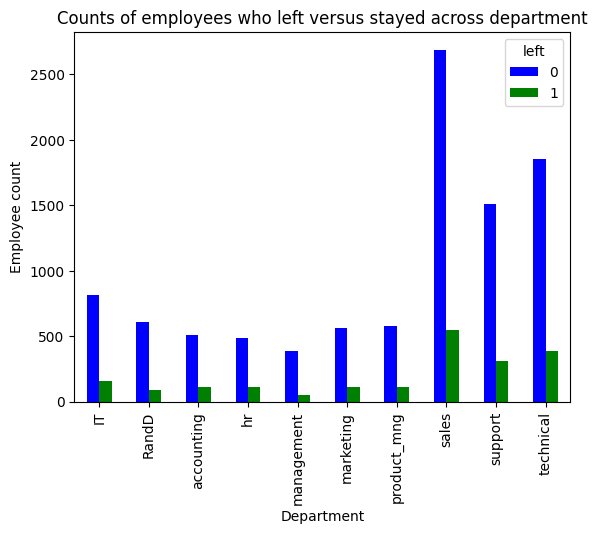

In [28]:
pd.crosstab(df1['department'], df1['left']).plot(kind = 'bar', color = 'bg')
plt.title('Counts of employees who left versus stayed across department')
plt.ylabel('Employee count')
plt.xlabel('Department')
plt.show()

In [29]:
df_logreg = df_enc[(df_enc['tenure'] >= lower_limit) & (df_enc['tenure']<= upper_limit)]

df_logreg.head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,left,promotion_last_5years,salary,department_IT,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical
0,0.38,0.53,2,157,3,0,1,0,0,False,False,False,False,False,False,False,True,False,False
2,0.11,0.88,7,272,4,0,1,0,1,False,False,False,False,False,False,False,True,False,False
3,0.72,0.87,5,223,5,0,1,0,0,False,False,False,False,False,False,False,True,False,False
4,0.37,0.52,2,159,3,0,1,0,0,False,False,False,False,False,False,False,True,False,False
5,0.41,0.50,2,153,3,0,1,0,0,False,False,False,False,False,False,False,True,False,False


In [30]:
y = df_logreg['left']

y.head()

0    1
2    1
3    1
4    1
5    1
Name: left, dtype: int64

In [31]:
X = df_logreg.drop('left', axis=1)

X.head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,promotion_last_5years,salary,department_IT,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical
0,0.38,0.53,2,157,3,0,0,0,False,False,False,False,False,False,False,True,False,False
2,0.11,0.88,7,272,4,0,0,1,False,False,False,False,False,False,False,True,False,False
3,0.72,0.87,5,223,5,0,0,0,False,False,False,False,False,False,False,True,False,False
4,0.37,0.52,2,159,3,0,0,0,False,False,False,False,False,False,False,True,False,False
5,0.41,0.50,2,153,3,0,0,0,False,False,False,False,False,False,False,True,False,False


In [32]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25,stratify=y, random_state = 42)

In [33]:
log_clf = LogisticRegression(random_state=42, max_iter = 500).fit(X_train,y_train)

In [34]:
y_pred = log_clf.predict(X_test)

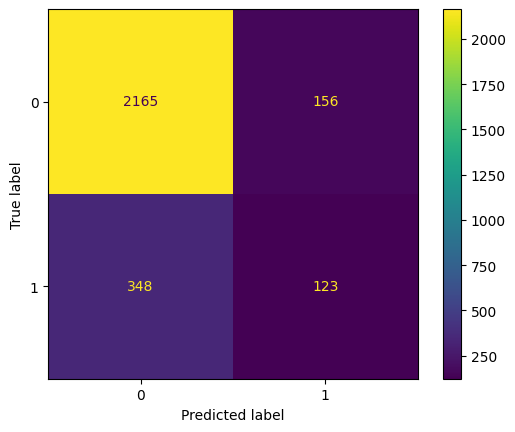

In [35]:
log_cm = confusion_matrix(y_test, y_pred, labels=log_clf.classes_)

log_disp = ConfusionMatrixDisplay(confusion_matrix = log_cm,display_labels=log_clf.classes_)

log_disp.plot(values_format= '')

plt.show()

In [36]:
df_logreg['left'].value_counts(normalize = True)

left
0    0.831468
1    0.168532
Name: proportion, dtype: float64

In [37]:
target_names = ['Predicted would not leave', 'Predicted would leave']
print(classification_report(y_test, y_pred, target_names = target_names))

                           precision    recall  f1-score   support

Predicted would not leave       0.86      0.93      0.90      2321
    Predicted would leave       0.44      0.26      0.33       471

                 accuracy                           0.82      2792
                macro avg       0.65      0.60      0.61      2792
             weighted avg       0.79      0.82      0.80      2792

